## Importing the Libraries

In [1]:
# Install the OpenSlide C library and Python bindings
!apt-get install openslide-tools
!pip install openslide-python

#Importing Libraries
#Importing Libraries
try:
  %tensorflow_version 2.x # enable TF 2.x in Colab
except Exception:
  pass
import tensorflow as tf

from keras.preprocessing import image
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
!apt-get install openslide-tools
!pip install openslide-python
from openslide import open_slide, __library_version__ as openslide_version
import numpy as np
import os
from PIL import Image
from skimage.color import rgb2gray
from tqdm import tqdm
import glob

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-430
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libopenslide0
Suggested packages:
  libtiff-tools
The following NEW packages will be installed:
  libopenslide0 openslide-tools
0 upgraded, 2 newly installed, 0 to remove and 7 not upgraded.
Need to get 92.5 kB of archives.
After this operation, 268 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libopenslide0 amd64 3.4.1+dfsg-2 [79.8 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 openslide-tools amd64 3.4.1+dfsg-2 [12.7 kB]
Fetched 92.5 kB in 1s (104 kB/s)
Selecting previously unselected package libopenslide0.
(Reading database ... 145674 files and directories currently installed.)
Preparing to unpack .../libopenslide0_3.4.1+dfsg-2_

Using TensorFlow backend.


Reading package lists... Done
Building dependency tree       
Reading state information... Done
openslide-tools is already the newest version (3.4.1+dfsg-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-430
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 7 not upgraded.


In [2]:
#Mounting Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## Utility Functions

In this section, we will define some utility functions that would be used throughout the notebook. The following functions would be created alongside the parameters to be supplied:

- **read_slide**: Read a WSI in .tiff format
  - `slide`: An OpenSlide object
  - `x` and `y`: Starting coordinates on the slide
  - `level`: The zoom level to head the image at
  - `width` and `height`: width, height of the image starting from `x` and `y` 

- **find_tissue_pixels**: Find the pixels in that contain the tissues in an image
  - `image`: numpy array of image

- **find_tissue_percentage**: 
  - `slide_image`: numpy array of image


In [0]:
#Read Slide
def read_slide(slide, x, y, level, width, height, as_float=False):
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im

In [0]:
#Get Tissue Percentage
def find_tissue_pixels(image, intensity=0.8):
    im_gray = rgb2gray(image)
    assert im_gray.shape == (image.shape[0], image.shape[1])
    indices = np.where(im_gray <= intensity)
    return list(zip(indices[0], indices[1]))

def tissue_percentage(slide_image):
  tissue_pixels = find_tissue_pixels(slide_image)
  percent_tissue = len(tissue_pixels) / float(slide_image.shape[0] * slide_image.shape[1]) * 100
  return percent_tissue

In [0]:
#Creating the Train Directory
colab_root = 'drive/My Drive/ADL Project'
train_folder = os.path.join(colab_root, 'Train Data No Mask')
os.mkdir(train_folder)

for i in range(8):
  folder = 'zoom_level_' + str(i)
  os.mkdir(os.path.join(train_folder, folder))
  positive_label = os.path.join(train_folder, folder, '1')
  os.mkdir(positive_label)
  negative_label = os.path.join(train_folder, folder, '0')
  os.mkdir(negative_label)

print('Mask Training Directories Created')

colab_root = 'drive/My Drive/ADL Project'
train_folder = os.path.join(colab_root, 'Train Data Mask')
os.mkdir(train_folder)

for i in range(8):
  folder = 'zoom_level_' + str(i)
  os.mkdir(os.path.join(train_folder, folder))
  positive_label = os.path.join(train_folder, folder, '1')
  os.mkdir(positive_label)
  negative_label = os.path.join(train_folder, folder, '0')
  os.mkdir(negative_label)

print('Slide Training Directories Created')

## Extract Patches

In this section, we extract the patches from the Whole-Slide-Images and store it on to the Google Drive. Functions in this section as below:

- **extract_patches**: Function to convolve over the images to extract patches
  - ```level```: level at which the images should be extracted
  - ```slide```: an OpenSlide object
  - ```tumor_mask```: Mask of the Image
  - ```stride```: Stride during convolution
  - ```dimension```: Tuple of dimensions (width, height)
  - ```image_num```: Identifier of the Image

In [0]:
#Extract Patches Helper Function
def extract_patches(level, slide, tumor_mask, stride, dimensions, image_num):
  downsamples = int(slide.level_downsamples[level])
  counter = 0
  positive_class = 0
  negative_class = 0
  image_num = str(image_num)

  for i in tqdm(range(slide.level_dimensions[level][0]//stride)):
    for j in range((slide.level_dimensions[level][1]//stride)):

      if (((i*stride*downsamples + dimensions[0]*downsamples)) <= slide.level_dimensions[0][0]) and (((j*stride*downsamples) + dimensions[1]*downsamples) <= slide.level_dimensions[0][1]):

        slide_to_save = read_slide(slide, x=i*stride*downsamples, y=j*stride*downsamples, level=level, width=dimensions[0], height=dimensions[1])
        mask = read_slide(tumor_mask, x=i*stride*downsamples, y=j*stride*downsamples, level=level, width=dimensions[0], height=dimensions[1])[:,:,0]
        
        if tissue_percentage(slide_to_save) >= 30:
          if np.where(mask == 1)[0].shape != (0,) and np.where(mask == 1)[1].shape != (0,):
            path = os.path.join('drive/My Drive/ADL Project/Train Data No Mask/zoom_level_'+str(level)+'/1', 'img_'+image_num+'_'+str(counter)+'.png')
            tumor_path = os.path.join('drive/My Drive/ADL Project/Train Data Mask/zoom_level_'+str(level)+'/1', 'mask_'+'img_'+image_num+'_'+str(counter)+'.png')
            plt.imsave(path, slide_to_save)
            plt.imsave(tumor_path, mask)
            positive_class += 1
            counter+=1
          else:
            path = os.path.join('drive/My Drive/ADL Project/Train Data No Mask/zoom_level_'+str(level)+'/0', 'img_'+image_num+'_'+str(counter)+'.png')
            tumor_path = os.path.join('drive/My Drive/ADL Project/Train Data Mask/zoom_level_'+str(level)+'/0', 'mask_'+'img_'+image_num+'_'+str(counter)+'.png')
            plt.imsave(path, slide_to_save)
            plt.imsave(tumor_path, mask)
            negative_class +=1
            counter+=1

  print('A total of ' + str(counter) + ' patches created.')
  print('Positive Class: ' + str(positive_class))
  print('Negative Class: ' + str(negative_class))

In [0]:
#Reading slide and mask files
mask_files = []
slide_files = []
for file in glob.glob("drive/My Drive/ADL Project/slides_local/*_mask.tif"):
  mask_files.append(file)

for file in glob.glob("drive/My Drive/ADL Project/slides_local/*.tif"):
  if (file not in mask_files) and ('tumor_038.tif' not in file):
    slide_files.append(file)

***Train-Test*** : We will now generate a 85-15 train test split. Since, we have 21 images in total, we will have 18 images in training set and 3 images in validation set.

In [0]:
#Train-Test Split: 85-15 Split
slide_files_train = slide_files[:-3]
mask_files_train = mask_files[:-3]

slide_files_test = slide_files[-3:]
mask_files_test = mask_files[-3:]

We will now extract patches at level 1-7 on all the 18 train images. We will specify the stride for convolution. The images would be stored in the Google Drive.  

In [0]:
#Extracting Patches for Level 1 - 7 (train images)
for i in range(len(mask_files_train)):
  print('File ' + str(i) + ' of ' + str(len(mask_files_train)))
  slide_path = slide_files_train[i]
  tumor_mask_path = mask_files_train[i]
  slide = open_slide(slide_path)
  tumor_mask = open_slide(tumor_mask_path)
  for j in range(7, 1, -1):
    print('Fetching Level: ' + str(j))
    extract_patches(j, slide, tumor_mask, 299, (299, 299), i)

## Model Training

In this section, we will build and train the model in this section. We will use transfer learning and use ***InceptionV3*** as the base model. On top of that model, we will add a ***Global Average Pooling*** layer and one dense layer containing one neuron with sigmoid activation.

In [5]:
#Loading InceptionV3 Model
base_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet', input_shape=(299,299,3))
base_model.trainable = True

#Defining Additional Layers - Global Average Pooling and the Final Dense Layer with Softmax activation
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(1, activation='sigmoid')

#Defining the model
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])

87916544/87910968 [==============================] - 2s 0us/step


We will now create a data generator and establish a **train-validation** split.

In [8]:
#Creating Input Data Generator
from tensorflow.keras.preprocessing.image import ImageDataGenerator

path = '/content/drive/My Drive/ADL Project/Train Data No Mask v2/zoom_level_2'

train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2) # set validation split

train_generator = train_datagen.flow_from_directory(path,
    target_size=(299, 299),
    batch_size=32,
    class_mode='binary',
    subset='training')

validation_generator = train_datagen.flow_from_directory(
    path,
    target_size=(299, 299),
    batch_size=32,
    class_mode='binary',
    subset='validation')

for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

Found 5787 images belonging to 2 classes.
Found 1446 images belonging to 2 classes.
data batch shape: (32, 299, 299, 3)
labels batch shape: (32,)


Since, the dataset is heavily imbalanced, we will establish different **class weights**.

In [9]:
#Defining Class Weight
neg_count = 0
pos_count = 0
for file in glob.glob("/content/drive/My Drive/ADL Project/Train Data No Mask v2/zoom_level_2/0/*"):
  neg_count += 1

for file in glob.glob("/content/drive/My Drive/ADL Project/Train Data No Mask v2/zoom_level_2/1/*"):
  pos_count += 1

class_weight = {0: 1,
                1: neg_count/pos_count}


print('Positive Class: ', pos_count)
print('Negative Class: ', neg_count)

weight_for_0 = (1 / neg_count)*(neg_count+pos_count)/2.0 
weight_for_1 = (1 / pos_count)*(neg_count+pos_count)/2.0

class_weight = {0: weight_for_0,
                1: weight_for_1}

print('Class Weight: ', class_weight)

Positive Class:  2006
Negative Class:  5227
Class Weight:  {0: 0.6918882724316051, 1: 1.80284147557328}


We will now define the metrics that we would use for evaluation. We will monior **True Positives**, **True Negatives, False Positives, False Negatives, Precision, Recall and AUC.**

Separately, we establish a **callback** to save the best weights based on validation AUC.

In [0]:
#Defining the metrics
METRICS = [
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
]

#Defining Checkpoints
checkpoint = tf.keras.callbacks.ModelCheckpoint("/content/drive/My Drive/ADL Project/model_l2.h5", monitor='val_auc', save_best_only=True, 
                                                mode='auto', save_weights_only=False)

Now we will compile and run the model. We will use **RMSProp** as the optimizer, **BinaryCrossEntropy** and train for 10 epochs.

In [11]:
#Compiling the model
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001, rho=0.95),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=METRICS)

#Fitting the model
history = model.fit_generator(
    train_generator,
    steps_per_epoch = train_generator.samples // 32,
    validation_data = validation_generator, 
    validation_steps = validation_generator.samples // 32,
    class_weight=class_weight,
    epochs = 10, callbacks=[checkpoint])

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 180 steps, validate for 45 steps
Epoch 1/10
180/180 [==============================] - 2833s 16s/step - loss: 0.2462 - tp: 1401.0000 - fp: 286.0000 - tn: 3870.0000 - fn: 198.0000 - accuracy: 0.9159 - precision: 0.8305 - recall: 0.8762 - auc: 0.9575 - val_loss: 1.3564 - val_tp: 225.0000 - val_fp: 10.0000 - val_tn: 1030.0000 - val_fn: 175.0000 - val_accuracy: 0.8715 - val_precision: 0.9574 - val_recall: 0.5625 - val_auc: 0.8613
Epoch 2/10
180/180 [==============================] - 62s 344ms/step - loss: 0.0865 - tp: 1540.0000 - fp: 87.0000 - tn: 4068.0000 - fn: 60.0000 - accuracy: 0.9745 - precision: 0.9465 - recall: 0.9625 - auc: 0.9942 - val_loss: 8.6173 - val_tp: 62.0000 - val_fp: 59.0000 - val_tn: 981.0000 - val_fn: 338.0000 - val_accuracy: 0.7243 - val_precision: 0.5124 - val_recall: 0.1550 - val_auc: 0.5876
Epoch 3/10
180/180 [=====================

Let us now plot **AUC** and **Loss** for different epochs.

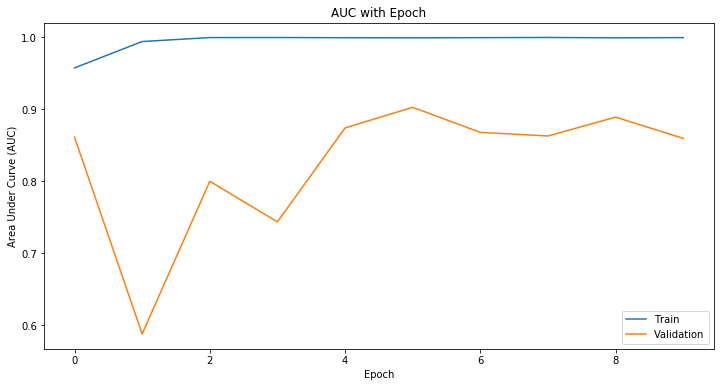

In [12]:
#Plotting Model Results - AUC
_ = plt.figure(figsize=(12,6))
_ = plt.plot(history.history['auc'], label='Train')
_ = plt.plot(history.history['val_auc'], label='Validation')
_ = plt.xlabel('Epoch')
_ = plt.ylabel('Area Under Curve (AUC)')
_ = plt.legend(loc='best')
_ = plt.title('AUC with Epoch')

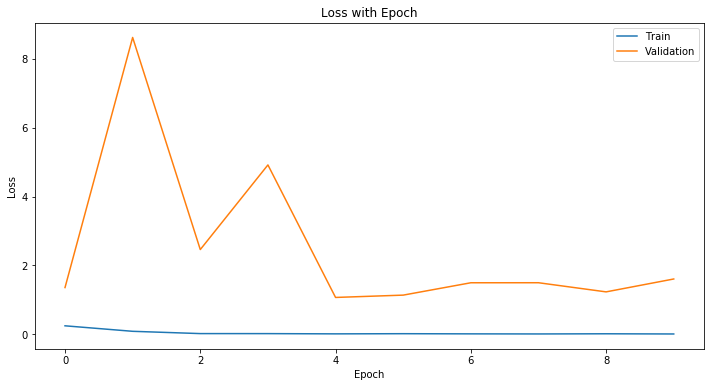

In [13]:
#Plotting Model Results - Loss
_ = plt.figure(figsize=(12,6))
_ = plt.plot(history.history['loss'], label='Train')
_ = plt.plot(history.history['val_loss'], label='Validation')
_ = plt.xlabel('Epoch')
_ = plt.ylabel('Loss')
_ = plt.legend(loc='best')
_ = plt.title('Loss with Epoch')

## Prediction and Generating Heatmap

In this section, we will now load the trained model and generate a probability heatmap. The functions defined in this section are:

- **extract_patches_heatmap**: Convolve over the WSI and perform prediction on individual patches.
  - **level**: Level at which predictions to be performed
  - **slide**: OpenSlide Object
  - **stride**: Stride for convolution (use 299)
  - **dimensions**: Dimensions of the patches (use 299 x 299 as the model is trained on that.
  - **model**: model to use for prediction

- **predict_patches**: Utility function for generating heatmap
  - **slide_path**: path of the test image
  - **level**: level at which prediction to be made
  - **model**: trained model

In [0]:
#Loading the model
trained_model = tf.keras.models.load_model('/content/drive/My Drive/ADL Project/model_l2.h5')

In [0]:
#Extract Patches Function
def extract_patches_heatmap(level, slide, stride, dimensions, model):
  downsamples = int(slide.level_downsamples[level])
  counter = 0
  positive_class = 0
  negative_class = 0
  mask_arr = np.array([[0]*299]*299)

  predictions_array = np.zeros((slide.level_dimensions[level][1]//299, slide.level_dimensions[level][0]//299))
  predictions_probabilities = np.zeros((slide.level_dimensions[level][1]//299, slide.level_dimensions[level][0]//299))

  for i in tqdm(range(slide.level_dimensions[level][0]//stride)):
    for j in range((slide.level_dimensions[level][1]//stride)):

      if (((i*stride*downsamples + dimensions[0]*downsamples)) <= slide.level_dimensions[0][0]) and (((j*stride*downsamples) + dimensions[1]*downsamples) <= slide.level_dimensions[0][1]):
        patch = read_slide(slide, x=i*stride*downsamples, y=j*stride*downsamples, level=level, width=dimensions[0], height=dimensions[1])
        if tissue_percentage(patch) >= 80:
          patch = image.img_to_array(patch)
          patch = patch/255.
          patch = np.expand_dims(patch, axis=0)
          prediction = model.predict(patch)
          
          predictions_probabilities[j, i] = prediction[0][0]
          if(prediction > 0.5):
            predictions_array[j, i] = 1
          else:
            predictions_array[j, i] = 0

        else:
          predictions_probabilities[j, i] = 0
          predictions_array[j, i] = 0
        counter += 1

  return predictions_array, predictions_probabilities

In [0]:
#Predict Patches
def predict_patches(slide_path, level, model):
  slide = open_slide(slide_path)
  print('Prediction on Level: ' + str(level))
  pred_arr, pred_prob = extract_patches_heatmap(level, slide , 299, (299, 299), model)
  _ = plt.figure(figsize=(10,10))
  _ = plt.matshow(pred_prob, fignum=1);
  _ = plt.colorbar()
  _ = plt.show()

  0%|          | 0/116 [00:00<?, ?it/s]

Prediction on Level: 2


100%|██████████| 116/116 [02:17<00:00,  2.37it/s]


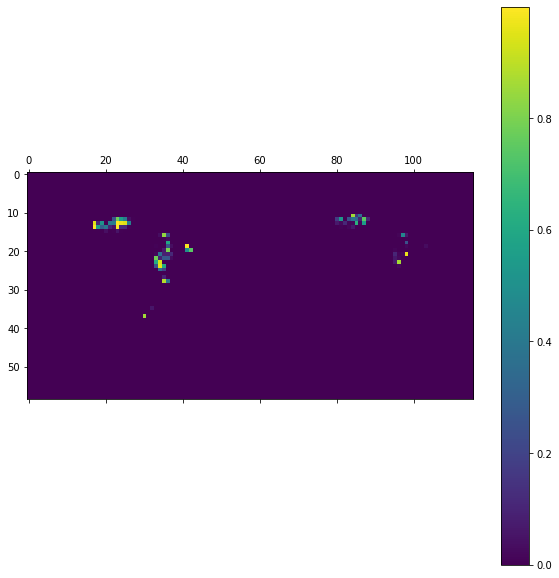

In [31]:
#Generating Heatmap for one Image
predict_patches(slide_path=slide_files_test[-2], level=2, model=trained_model)